In [221]:
import nltk
from nltk.corpus import stopwords 
from nltk.corpus import inaugural
from nltk.tokenize import word_tokenize, sent_tokenize
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator,FormatStrFormatter,AutoMinorLocator)
import pyphen
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from pysyllables import get_syllable_count
import re
import string
pyphen.language_fallback('nl_NL_variant1')
dic = pyphen.Pyphen(lang='nl_NL')
from collections import Counter
stop_words = set(stopwords.words('english'))

In [222]:
# Methods to scrape ucsb site for speech transcripts
# code reference : https://medium.com/@med.taha.elahmar/an-nlp-case-study-with-us-presidents-inaugural-speeches-part-1-2-data
#-collection-and-f1e2c5df5e50
def get_urls(url):
    '''Returns list of transcript urls'''
    page = requests.get(url).text
    soup=BeautifulSoup(page, 'lxml')
    url_table = soup.find("table", class_='table').find_all("a")
    return [u["href"] for u in url_table]

def get_transcripts(urls, transcripts):
    for u in urls:
        page = requests.get(u).text
        soup = BeautifulSoup(page, 'lxml')
        t_president = soup.find("h3", class_="diet-title").text
        t_year = soup.find("span", class_="date-display-single").text.split(',')[1].strip()
        t_content = soup.find("div", class_="field-docs-content").text 
        record = {
            'president' : t_president,
            'year' : float(t_year),
            'content' : t_content
        }
        transcripts = transcripts.append(record, ignore_index=True)
    return transcripts

In [223]:
urls = get_urls("https://www.presidency.ucsb.edu/documents/presidential-documents-archive-guidebook/inaugural-addresses")
to_del = [1,4,6,8,11,19,21,26,28,32,37,38,39,42,46,49,52,54,56]

# Removing second term inaugural speeches
url_list = []
for i in range (0,len(urls)):
    if (i in to_del):
        continue
    else:
        url_list.append(urls[i])
        
transcripts = pd.DataFrame()
data = get_transcripts(url_list,transcripts)
# now, 'data' holds information for the president, speech content, and year of the inaugural speeches

In [228]:
def print_outliers(list_):
    q1, q3= np.percentile(list_,[25,75])
    iqr = q3 - q1

    lower_bound = q1 -(1.5 * iqr) 
    upper_bound = q3 +(1.5 * iqr) 

    #prints if there are any outliers
    i=0
    for num in list_:
        if num < lower_bound:
            print("lower bound: ", i, " ", num)
        if num > upper_bound:
            print("upper bound: ", i, " ", num)
        i+=1

a)

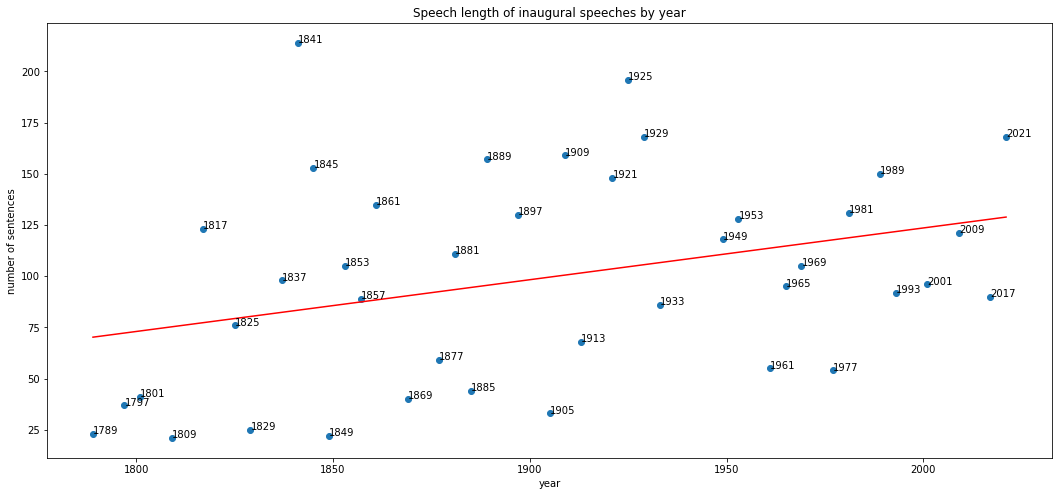

In [229]:
#How long are the speeches in terms of number of sentences?
num_sentences = []
for i in range (len(data["content"])):
    x = len(sent_tokenize(data["content"][i]))   
    num_sentences.append(x)
    

fig, ax = plt.subplots()
labels = [int(x) for x in data["year"]] 
for i, txt in enumerate(labels):
    ax.annotate(txt, (data["year"][i], num_sentences[i]))
ax.scatter(data["year"],num_sentences)
plt.title("Speech length of inaugural speeches by year")
plt.xlabel("year")
plt.ylabel("number of sentences")
fig.set_size_inches(18, 8)

x= np.array(data["year"])
y = np.array(num_sentences)
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, 'r')
plt.show()

print_outliers(num_sentences)

In [170]:
# need to clean text before tokenizing by word
def clean_text(speech):
    text = speech
    text = text.lower()
    text = re.sub('—\[.*?\]', '', text)
    text = re.sub('—', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('[\d\n]', ' ', text)
    return text

cleaned_text = []
for i in range (len(data["content"])):
    cleaned_text.append(clean_text(data["content"][i]))

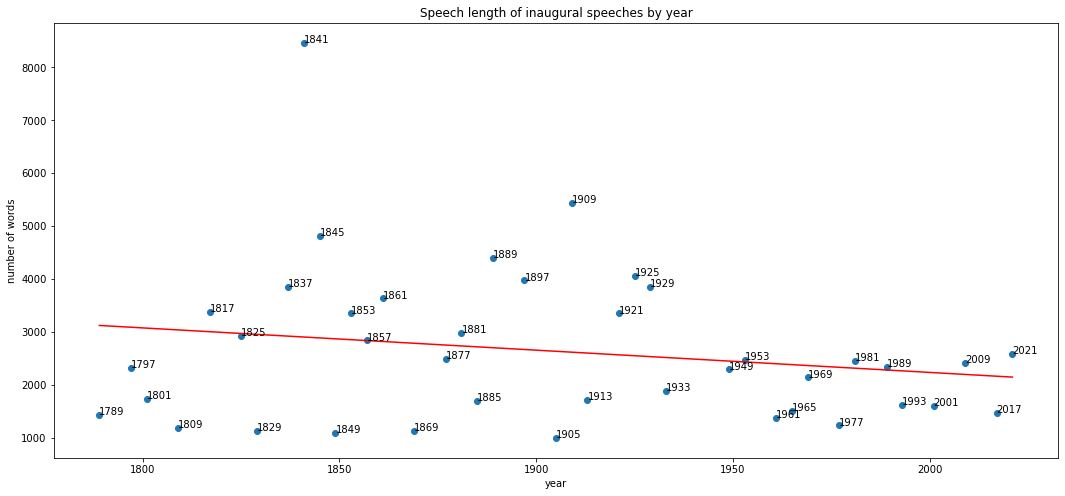

upper bound:  8   8469


In [230]:
# How long are the speeches as a number of words?
num_words = []

for i in range (len(cleaned_text)):
    word_tokens = word_tokenize(cleaned_text[i])
    num_words.append(len(word_tokens))
    

fig, ax = plt.subplots()
for i, txt in enumerate(labels):
    ax.annotate(txt, (data["year"][i], num_words[i]))
ax.scatter(data["year"],num_words)
plt.title("Speech length of inaugural speeches by year")
plt.xlabel("year")
plt.ylabel("number of words")
fig.set_size_inches(18, 8)
x= np.array(data["year"])
y = np.array(num_words)
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, 'r')

plt.show()

print_outliers(num_words)

b)

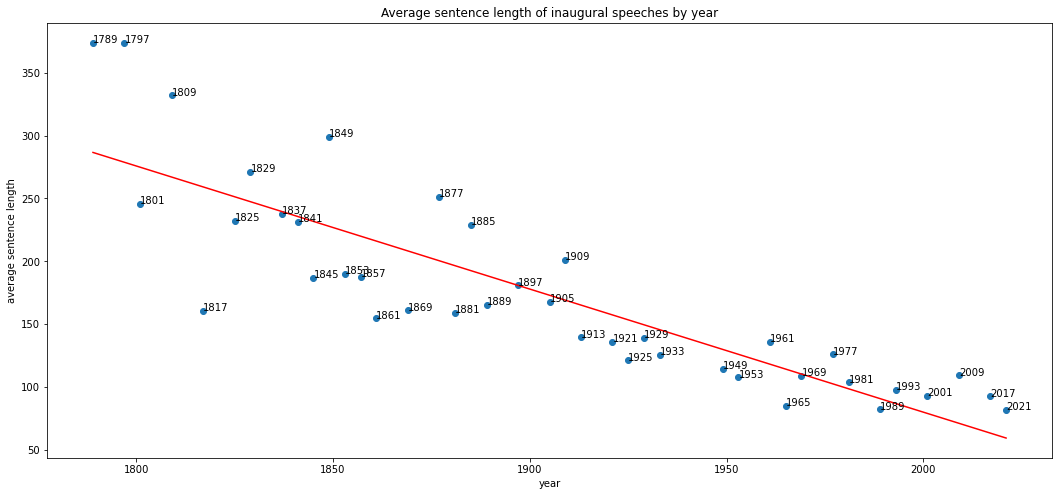

In [231]:
# What is the average sentence length (in words) of all speeches?
def avg_sentence_length(speech):
    tokenized = sent_tokenize(speech)
    num_words_per_sent = []
    
    for i in range (len(tokenized)):
        word_tokens = tokenized[i]
        word_tokens = clean_text(word_tokens)
        x = len(word_tokens)
        num_words_per_sent.append(x)
    
    avg = (sum(num_words_per_sent)) / len(tokenized)
    return avg

avg_sentences = []
for i in range (len(data["content"])):
    avg_sentences.append(avg_sentence_length(data["content"][i]))

    
fig, ax = plt.subplots()
for i, txt in enumerate(labels):
    ax.annotate(txt, (data["year"][i], avg_sentences[i]))
ax.scatter(data["year"],avg_sentences)
plt.title("Average sentence length of inaugural speeches by year")
plt.xlabel("year")
plt.ylabel("average sentence length")
fig.set_size_inches(18, 8)
x= np.array(data["year"])
y = np.array(avg_sentences)
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, 'r')
plt.show()

print_outliers(avg_sentences)

c)

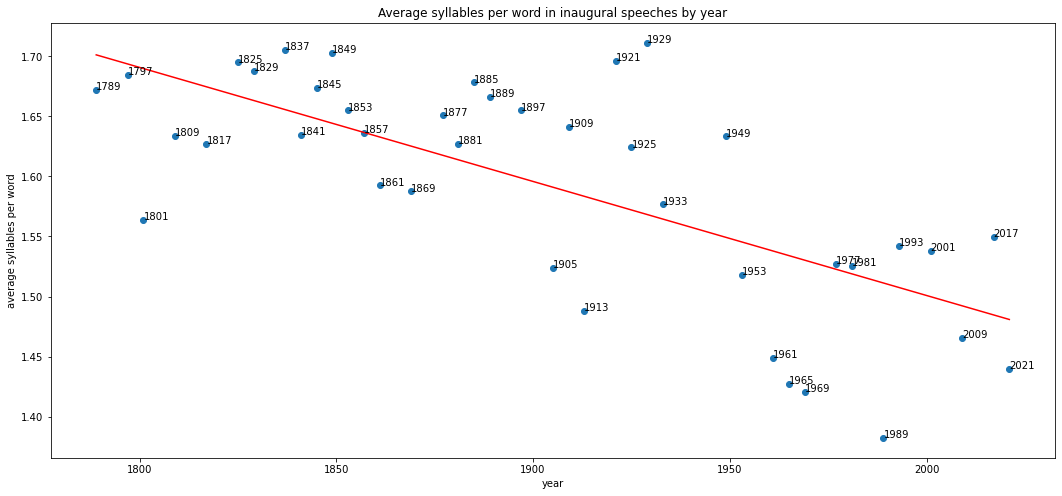

In [233]:
def avg_num_syllables(text):
    word_tokens = word_tokenize(text)
    syllables = []
    
    for i in range(len(word_tokens)):
        x = get_syllable_count(word_tokens[i])
        
        if x == None:
            hyphenated = dic.inserted('lettergrepen')
            hyphen_count = hyphenated.count("-")
            x = hyphen_count+1
        syllables.append(x)

    avg = sum(syllables) / len(syllables)
    return avg


avg_syllables = []
for i in range (len(cleaned_text)):
    avg_syllables.append(avg_num_syllables(cleaned_text[i]))

fig, ax = plt.subplots()
for i, txt in enumerate(labels):
    ax.annotate(txt, (data["year"][i], avg_syllables[i]))
ax.scatter(data["year"],avg_syllables)
plt.title("Average syllables per word in inaugural speeches by year")
plt.xlabel("year")
plt.ylabel("average syllables per word")
fig.set_size_inches(18, 8)
x= np.array(data["year"])
y = np.array(avg_syllables)
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, 'r')

plt.show()
print_outliers(avg_syllables)

d)

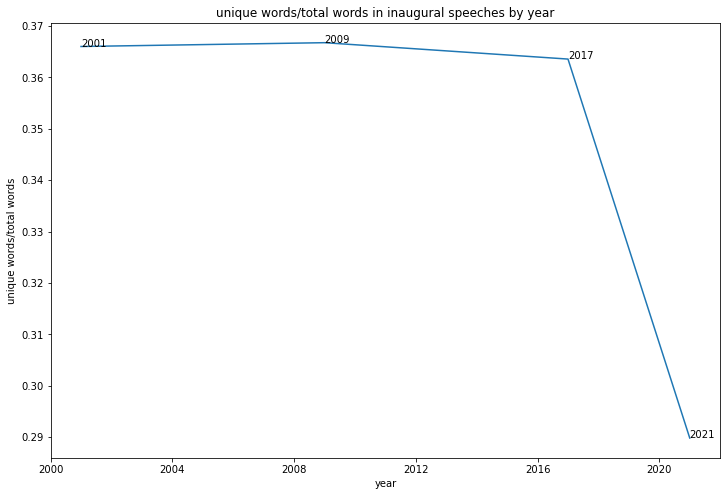

In [235]:
#plot number of unique words
def unique_words_in_speech(speech, remove_stopwords):
    word_tokens = word_tokenize(speech)
    unique = []
    if remove_stopwords == True:
        filtered = [w for w in word_tokens if not w.lower() in stop_words]
        unique = set(filtered)
    else:
        unique = set(word_tokens)
    
    return len(unique) / len(word_tokens)
    
# without removing stopwords
list_unique = []
for i in range (36,40):
    x = unique_words_in_speech(cleaned_text[i],False)
    list_unique.append(x)

fig, ax = plt.subplots()
last_4_labels = [2001,2009,2017,2021]
for i, txt in enumerate(last_4_labels):
    ax.annotate(txt, (last_4_years[i], list_unique[i]))
ax.plot(last_4_years,list_unique)
ax.xaxis.set_major_locator(MultipleLocator(4))
plt.title("unique words/total words in inaugural speeches by year")
plt.xlabel("year")
plt.ylabel("unique words/total words")
fig.set_size_inches(12, 8)
plt.show()

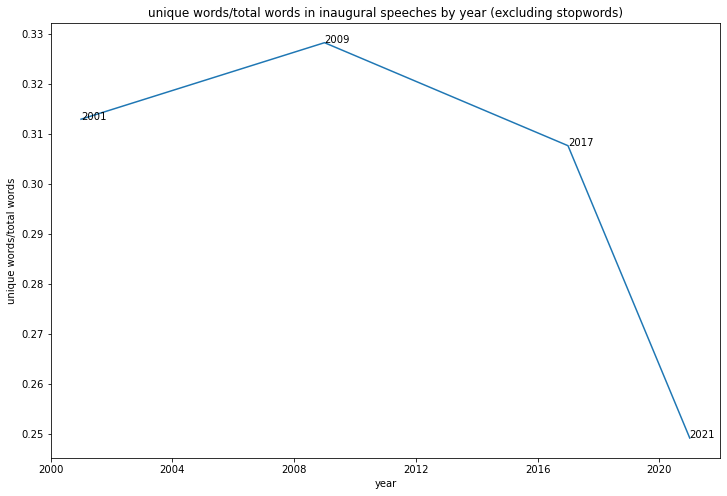

In [234]:
#plot number of unique words(without stopwords)
list_unique = []
for i in range (36,40):
    x = unique_words_in_speech(cleaned_text[i], True)
    list_unique.append(x)


fig, ax = plt.subplots()
last_4_labels = [2001,2009,2017,2021]
for i, txt in enumerate(last_4_labels):
    ax.annotate(txt, (last_4_years[i], list_unique[i]))
ax.plot(last_4_years,list_unique)
ax.xaxis.set_major_locator(MultipleLocator(4))
plt.title("unique words/total words in inaugural speeches by year (excluding stopwords)")
plt.xlabel("year")
plt.ylabel("unique words/total words")
fig.set_size_inches(12, 8)
plt.show()

In [237]:
#Look at the top 20 most frequent non-stop words 
def freq_unique_words(speech_tokens):
    freq = Counter(speech_tokens)
    most_occur = freq.most_common(20)
    df = pd.DataFrame(most_occur, columns =['Word','Frequency'])
    print(df)
    
# without removing stopwords
for i in range (36,40):
    print(data["president"][i])   
    speech_tokens = word_tokenize(cleaned_text[i])
    freq_unique_words(speech_tokens)
    print("\n")

George W. Bush
       Word  Frequency
0       and         82
1        of         58
2       the         53
3       our         50
4         a         47
5        we         47
6        to         45
7        is         31
8        in         30
9       not         27
10     will         23
11      are         19
12     that         18
13       it         16
14      for         12
15      but         12
16     this         12
17        i         11
18   nation         11
19  america         11


Barack Obama
    Word  Frequency
0    the        132
1    and        111
2     of         82
3     to         70
4    our         67
5     we         62
6   that         49
7      a         47
8     is         36
9     in         25
10  this         24
11    us         23
12   for         23
13   not         22
14   are         22
15   but         20
16    it         19
17  will         19
18   can         19
19    on         17


Donald J. Trump
       Word  Frequency
0       and         76
1  

In [220]:
# after removing stopwords
for i in range (36,40):
    print(data["president"][i])   
    speech_tokens = word_tokenize(cleaned_text[i])
    filtered = [w for w in speech_tokens if not w.lower() in stop_words]
    freq_unique_words(filtered)
    print("\n")  

George W. Bush
         Word  Frequency
0      nation         11
1     america         11
2          us         11
3       story         10
4    citizens          9
5     country          9
6        must          6
7       every          6
8   president          5
9      common          5
10        new          5
11       many          5
12    freedom          5
13    promise          5
14  americans          5
15       know          5
16      never          5
17    courage          5
18    justice          4
19        yet          4


Barack Obama
          Word  Frequency
0           us         23
1       nation         12
2          new         11
3      america         10
4        every          8
5         must          8
6        today          7
7       people          7
8         less          7
9        world          7
10         let          7
11        time          6
12        work          6
13      common          6
14  generation          5
15         day          5
16 